 # COVID-19 Data Analysis - Predicting the Evolution in Brazil with ARIMA & Prophet

I used the data generated from previous ETL code and available on CSSEGISandData Github - https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

In [9]:
# libraries
#!pip install plotly
import pandas as pd
import pandera as pa
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

### Importing & Filtering Dataset

In [10]:
# Importing data
# Confirmed
url_conf = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_conf = pd.read_csv(url_conf)
# Deaths
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
df_deaths = pd.read_csv(url_deaths)

In [11]:
# Changing shape of the df - passing dates to lines
data_conf = pd.melt(df_conf, id_vars=['Province/State','Country/Region', 'Lat', 'Long'], 
var_name='Date', value_name='Confirmed')
data_conf.columns = ['Province', 'Country', 'Lat', 'Long', 'Dates', 'Confirmed']

# Changing shape of the df - passing dates to lines
data_deaths = pd.melt(df_deaths, id_vars=['Province/State','Country/Region', 'Lat', 'Long'], 
var_name='Date', value_name='Deaths')
data_deaths.columns = ['Province', 'Country', 'Lat', 'Long', 'Dates', 'Deaths']

# Removing unuseful cols
data_conf.drop(['Province', 'Lat', 'Long'], axis = 1, inplace = True)
data_deaths.drop(['Province', 'Lat', 'Long'], axis = 1, inplace = True)

In [12]:
# Checking data schema
data_conf['Dates'] = pd.to_datetime(data_conf['Dates'], format="%m/%d/%y")

schema = pa.DataFrameSchema(
    columns = {
        "Country": pa.Column(pa.String),
        "Dates": pa.Column(pa.DateTime),
        "Confirmed": pa.Column(pa.Int)
    }
)

schema.validate(data_conf)

data_deaths['Dates'] = pd.to_datetime(data_deaths['Dates'], format="%m/%d/%y")

schema = pa.DataFrameSchema(
    columns = {
        "Country": pa.Column(pa.String),
        "Dates": pa.Column(pa.DateTime),
        "Deaths": pa.Column(pa.Int)
    }
)

schema.validate(data_deaths)

,Country,Dates,Deaths
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0
...,...,...,...
159862,Vietnam,2021-08-16,6141
159863,West Bank and Gaza,2021-08-16,3625
159864,Yemen,2021-08-16,1405
159865,Zambia,2021-08-16,3538


In [13]:
# Binding dfs
data_conf['Deaths'] = data_deaths['Deaths']
data_conf.head()

,Country,Dates,Confirmed,Deaths
0,Afghanistan,2020-01-22,0,0
1,Albania,2020-01-22,0,0
2,Algeria,2020-01-22,0,0
3,Andorra,2020-01-22,0,0
4,Angola,2020-01-22,0,0


In [14]:
# Selecting Brazil
filter1 = (data_conf.Country=='Brazil') & (data_conf.Deaths>0) & (data_conf.Confirmed>0)

data = data_conf.loc[filter1] 
data.head()

,Country,Dates,Confirmed,Deaths
15375,Brazil,2020-03-17,321,1
15654,Brazil,2020-03-18,372,3
15933,Brazil,2020-03-19,621,6
16212,Brazil,2020-03-20,793,11
16491,Brazil,2020-03-21,1021,15


### Confirmed Cases

In [15]:
# Evolution of confirmed cases
px.line(data, 'Dates', 'Confirmed', title='Confirmed Cases in Brazil')

### New Cases by Day

In [16]:
data['newcases']=list(map(
    lambda x: 0 if (x==0) else data['Confirmed'].iloc[x] - data['Confirmed'].iloc[x-1],
    np.arange(data.shape[0])
))

<ipython-input-16-32dc8658fb5c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
px.line(data, x='Dates', y='newcases', title='New Cases by Day')

### Deaths

In [18]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=data.Dates, y=data.Deaths, name='Deaths',
              mode='lines+markers', line={'color':'red'})
)

# layout
fig.update_layout(title='Deaths by COVID-19 in Brazil')

fig.show()

### Growing Rate

In [19]:
#growing_rate = (present/past)**(1/n)-1

def growing_rate(data, var, startdate=None, enddate=None):
    # if startdate = None
    if startdate == None:
        startdate = data.Dates.loc[data[var]>0].min()
    else:
        startdate = pd.to_datetime(startdate)
    if enddate == None:
        enddate = data.Dates.iloc[-1]
    else:
        enddate = pd.to_datetime(enddate)
    
    # define present and past values
    past = data.loc[data.Dates == startdate, var].values[0]
    present = data.loc[data.Dates == enddate, var].values[0]
    
    # define number of time points will be evaluated
    n = (enddate - startdate).days
    
    # calculate ratio
    ratio = (present/past)**(1/n)-1
    
    return ratio*100

### Mean of Growth Ratio of Covid in Brazil

In [20]:
growing_rate(data, 'Confirmed')

2.1620254335131817

In [21]:
def growing_ratio_day(data, var, startdate=None):
    # if startdate = None
    if startdate == None:
        startdate = data.Dates.loc[data[var]>0].min()
    else:
        startdate = pd.to_datetime(startdate)
    
    enddate = data.Dates.max()
    
    # number of time points evaluated
    n = (enddate-startdate).days
    
    # ratio by day
    ratios = list(map(
        lambda x: (data[var].iloc[x] - data[var].iloc[x-1])/data[var].iloc[x-1],
        range(1, n+1)
    ))
    return np.array(ratios)*100

In [22]:
day_ratio = growing_ratio_day(data, 'Confirmed')

In [23]:
#day_ratio

In [24]:
firstday = data.Dates.loc[data.Confirmed>0].min()

px.line(x=pd.date_range(firstday, data.Dates.max())[1:],
       y=day_ratio, title='Growth Ratio of Confirmed Cases in Brazil',
       labels={'y':'Growth Ratio', 'x':'Date'})

### Prediction of Confirmed Cases

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [26]:
confirmed = data.Confirmed
confirmed.index = data.Dates
res = seasonal_decompose(confirmed)

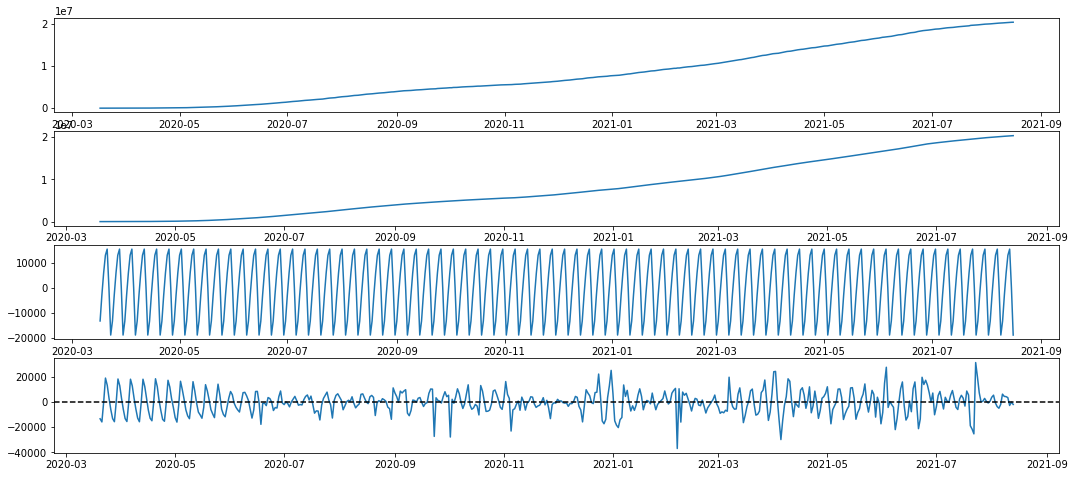

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(18,8))

ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.plot(confirmed.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

### ARIMA Model

In [28]:
#!pip install pyramid-arima
from pmdarima.arima import auto_arima

In [29]:
model =  auto_arima(confirmed)

In [30]:
fig = go.Figure(go.Scatter(
    x=confirmed.index, y=confirmed, name='Observed'
))

fig.add_trace(go.Scatter(
    x=confirmed.index, y=model.predict_in_sample(), name='Predicted'
))

fig.add_trace(go.Scatter(
    x=pd.date_range('2021-08-17', '2021-09-17'), y=model.predict(31), name='Forecast'
))

fig.update_layout(title='Predictions of Confirmed Cases in Brazil to Next 30 Days')
fig.show()

### Growth Model with fbprophet

In [31]:
#!pip install pystan==2.19.1.1 prophet

In [32]:
from prophet import Prophet

train = confirmed.reset_index()[:-5]
test = confirmed.reset_index()[-5:]

# renaming columns
train.rename(columns={'Dates': 'ds', 'Confirmed':'y'}, inplace=True)
test.rename(columns={'Dates': 'ds', 'Confirmed':'y'}, inplace=True)

# defining the model

proph = Prophet(growth='logistic', changepoints=['2021-07-21', '2021-07-30', '2021-08-01',
                                                '2021-08-03', '2021-08-10'])

pop = 211463256 # brazil population size
train['cap'] = pop

# train the model
proph.fit(train)

# construction the future predictions
future_dates = proph.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast = proph.predict(future_dates)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predictions'))
#fig.add_trace(go.Scatter(x=test.index, y=test, name='Observed - Test'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observed - Train'))
fig.update_layout(title='Predictions of Confirmed Cases in Brazil')
fig.show()

In [34]:
# Mobile mean last 7 days
data['ConfirmedMM'] = data.Confirmed.rolling(7).mean()
data['DeathMM'] = data.Deaths.rolling(7).mean() 

<ipython-input-34-2e40d7a0c8df>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-2e40d7a0c8df>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
data.head(10)

,Country,Dates,Confirmed,Deaths,newcases,ConfirmedMM,DeathMM
15375,Brazil,2020-03-17,321,1,0,NaN,NaN
15654,Brazil,2020-03-18,372,3,51,NaN,NaN
15933,Brazil,2020-03-19,621,6,249,NaN,NaN
16212,Brazil,2020-03-20,793,11,172,NaN,NaN
16491,Brazil,2020-03-21,1021,15,228,NaN,NaN
16770,Brazil,2020-03-22,1546,25,525,NaN,NaN
17049,Brazil,2020-03-23,1924,34,378,NaN,13.571429
17328,Brazil,2020-03-24,2247,46,323,NaN,20.000000
17607,Brazil,2020-03-25,2554,59,307,NaN,28.000000
17886,Brazil,2020-03-26,2985,77,431,NaN,38.142857


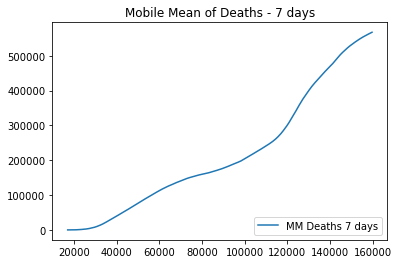

In [36]:
plt.plot(data['Deaths'].rolling(7).mean(),label= 'MM Deaths 7 days')
plt.legend(loc='lower right')
plt.title('Mobile Mean of Deaths - 7 days')
plt.show()

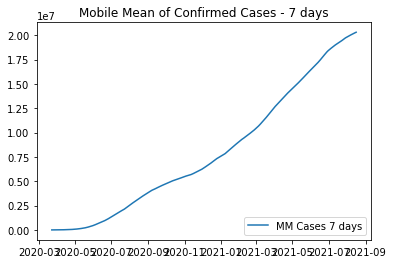

In [37]:
plt.plot(data['Confirmed'].rolling(7).mean(),label= 'MM Cases 7 days')
plt.legend(loc='lower right')
plt.title('Mobile Mean of Confirmed Cases - 7 days')
plt.show()